<a href="https://colab.research.google.com/github/DeepLearningSaeid/Grad/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
# Install Autokeras library
!pip install autokeras

# Import required libraries
import autokeras as ak
import timeit
import numpy as np
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Activation
from keras import backend as K
from keras.utils import get_custom_objects
from keras.utils import np_utils, to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist


# Set random seed
np.random.seed(110)


In [2]:
# Defining new activation functions
def define_activation_functions():
    """
    Define custom activation functions and update the custom objects dictionary.
    """
    # Define activation functions and their respective names
    activation_functions = [
        ('X_1', lambda x: K.pow(x, 1)),
        ('X_2', lambda x: K.pow(x, 2) / 2),
        ('X_2_', lambda x: K.pow(x, 2) / 24),
        ('X_2__', lambda x: K.pow(x, 2) / 720),
        ('X_2___', lambda x: K.pow(x, 2) / 40320),
        ('X_3', lambda x: K.pow(x, 3) / 6),
        ('X_4', lambda x: K.pow(x, 4) / 24),
        ('X_5', lambda x: K.pow(x, 5) / 120),
        ('X_6', lambda x: K.pow(x, 6) / 720),
        ('X_7', lambda x: K.pow(x, 7) / 5040),
        ('X_8', lambda x: K.pow(x, 8) / 40320),
        ('X_9', lambda x: K.pow(x, 8) / 362880),
    ]

    # Update the custom objects dictionary with the defined activation functions
    for name, function in activation_functions:
        get_custom_objects().update({name: Activation(function)})

# Define and register the custom activation functions
define_activation_functions()


In [3]:
# Create SWAG Model with 4 Layers
def create_swag_model(input_dim, hidden_dim, output_dim, activations):
    """
    Create a SWAG model with two layers of concatenated sub-layers.
    
    Args:
        input_dim (int): The input dimension.
        hidden_dim (int): The hidden dimension.
        output_dim (int): The output dimension.
        activations (list): A list of activation functions for each sub-layer.
        
    Returns:
        model (Model): A Keras model.
    """
    # Define the input layer
    input_layer = Input(shape=(input_dim,))
    
    # Create the first layer with sub-layers using different activation functions
    layer1_sublayers = [Dense(hidden_dim, activation=act)(input_layer) for act in activations]
    
    # Concatenate the first layer's sub-layers
    layer1_concat = concatenate(layer1_sublayers)
    
    # Create a dense layer after concatenation
    layer1_output = Dense(hidden_dim, activation='linear')(layer1_concat)
    
    # Create the second layer with sub-layers using different activation functions
    layer2_sublayers = [Dense(hidden_dim, activation=act)(layer1_output) for act in activations]
    
    # Concatenate the second layer's sub-layers
    layer2_concat = concatenate(layer2_sublayers)
    
    # Create the output layer
    output_layer = Dense(output_dim, activation='linear')(layer2_concat)
    
    # Define the model
    model = Model(input_layer, output_layer)
    
    # Print model summary
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# Define input and hidden dimensions, output dimensions, and activation functions
input_dim = 1
hidden_dim = 50
output_dim = 1
activations = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8']

# Create the SWAG model
model = create_swag_model(input_dim, hidden_dim , output_dim, activations)


In [4]:
def create_optimized_model(input_dim,  hidden_dim , output_dim ):
    """
    Create an optimized SWAG model with a custom architecture.

    :param input_dim: int, dimension of the input data
    :param output_dim: int, dimension of the output data
    :param hidden_dim: int, hidden layer dimension, default is 50
    :return: Model, a compiled Keras model
    """

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # First layer with custom activations
    layer_1_x1 = Dense(hidden_dim, activation='X_1')(input_layer)
    layer_1_x2 = Dense(hidden_dim, activation='X_2')(input_layer)
    concat_first_layer = concatenate([layer_1_x1, layer_1_x2])

    # Second layer with custom activations
    layer_x3_x4 = Dense(hidden_dim, activation='X_2_')(concat_first_layer)

    # Third layer with custom activations
    layer_x5_x6 = Dense(hidden_dim, activation='X_2__')(layer_x3_x4)

    # Fourth layer with custom activations
    layer_x7_x8 = Dense(hidden_dim, activation='X_2___')(layer_x5_x6)

    # Concatenate all layers
    concat_second_layer = concatenate([layer_1_x1, layer_1_x2, concat_first_layer,
                                       layer_x3_x4, layer_x5_x6, layer_x7_x8])

    # Output layer for the concatenated layers
    output_first_layer = Dense(hidden_dim, activation='linear')(concat_second_layer)

    # Final output layer
    output_layer = Dense(output_dim, activation='linear')(output_first_layer)

    # Create and compile the model
    model = Model(input_layer, output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Set input and output dimensions
input_dim = 1
output_dim = 1

# Create and compile the optimized model
optimized_model = create_optimized_model(input_dim,hidden_dim, output_dim)
optimized_model = create_swag_model(input_dim, hidden_dim , output_dim, activations)


In [5]:
def power(x, n):
    """
    Raise x to the power of n.

    :param x: float, base number
    :param n: int, exponent
    :return: float, x raised to the power of n
    """
    return np.power(x, n)

def sigmoid_array(x):
    """
    Apply the sigmoid function to the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, sigmoid of input value(s)
    """
    return 1 / (1 + np.exp(-x))

def exp(x):
    """
    Calculate the exponential of the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, exponential of input value(s)
    """
    return np.exp(x)

def log(x):
    """
    Calculate the natural logarithm of the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, natural logarithm of input value(s)
    """
    return np.log(x)

def generate_random(shape_1, shape_2):
    """
    Generate a random matrix with uniform distribution.

    :param shape_1: int, number of rows
    :param shape_2: int, number of columns
    :return: array-like, random matrix of shape (shape_1, shape_2)
    """
    temp = np.random.uniform(low=0.01, high=0.99, size=(shape_1 * shape_2))
    temp1 = temp.reshape(shape_1, shape_2)
    return temp1

def fun_1(x):
    """
    Compute the value of the custom function 1.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 1
    """
    return 1 / 2 * power(x, 2) - 5 * sigmoid_array(x)

def fun_2(x):
    """
    Compute the value of the custom function 2.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 2
    """
    return 6 * power(x, 5) - 3 * sigmoid_array(x) + exp(x) - 9 * log(x)

def fun_3(x):
    """
    Compute the value of the custom function 3.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 3
    """
    return 22 * power(x, 20) + sigmoid_array(x) + 2 * exp(x) + 5 * log(x)


In [6]:


def plot_loss(size, in_1, in_2, in_3, in_4, in_5):
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 12})
    
    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        
        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)
        
        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')
        
        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Set y-axis limit
        plt.ylim(0, size)
        
        # Add title to subplot
        plt.title(title)
    
    # Create figure with 6 subplots
    plt.figure(figsize=(20, 12))
    
    # Plot training and test loss for each model architecture
    plot_subplot(231, in_1, 'Architecture 1')
    plot_subplot(232, in_2, 'Architecture 2')
    plot_subplot(233, in_3, 'Auto_Keras ')
    plot_subplot(234, in_4, 'Random Search')
    plot_subplot(235, in_5, 'SWAG')



def plot_shape(in_1,in_2,in_3,in_4,in_5):
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20,10))
    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the first subplot with the input data
    plt.subplot(231)
    plt.scatter(in_1[0], in_1[1])
    plt.scatter(in_1[0], in_1[2])
    plt.title('Architure 1')

    # Plot the second subplot with the input data
    plt.subplot(232)
    plt.scatter(in_2[0], in_2[1])
    plt.scatter(in_2[0], in_2[2])
    plt.title('Architure 2')

    # Plot the third subplot with the input data
    plt.subplot(233)
    plt.scatter(in_3[0], in_3[1])
    plt.scatter(in_3[0], in_3[2])
    plt.title('Auto Keras')

    # Plot the fourth subplot with the input data
    plt.subplot(234)
    plt.scatter(in_4[0], in_4[1])
    plt.scatter(in_4[0], in_4[2])
    plt.title('Random Search')
    
    # Plot the fifth subplot with the input data
    plt.subplot(235)
    plt.scatter(in_5[0], in_5[1])
    plt.scatter(in_5[0], in_5[2])
    plt.title('SWAG')    
    

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()


In [30]:
def plot_loss(history):
    """
    Plot the training and test loss using the history object.

    :param history: History object, training history of the model
    """
    # Retrieve the training and test loss values
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Generate epoch count
    epoch_count = range(1, len(training_loss) + 1)

    # Plot the training and test loss
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def visualize_results(history, X_test, Y_test, model):
    """
    Visualize the results of a trained model by plotting the loss curve and comparing true
    test data with the model's predicted output.

    :param history: History object, training history of the model
    :param X_test: array-like, test input data
    :param Y_test: array-like, test output data (true values)
    :param model: trained model to visualize
    """
    # Plot the loss curve
    plot_loss(history)
    
    # Scatter plot of the true test data
    plt.scatter(X_test, Y_test, label='True data')
    
    # Scatter plot of the model's predicted output
    predictions = model.predict(X_test)
    plt.scatter(X_test, predictions, label='Predicted data')

    plt.legend()
    plt.show()


In [ ]:
def visualize_predictions(data_list, title_list):
    """
    Visualize the predictions for multiple model architectures.

    :param data_list: list, list of tuples containing test input data, test output data (true values),
                      and model predictions for each model architecture
    :param title_list: list, list of titles corresponding to each model architecture
    """
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20, 10))

    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the subplots with the input data
    for i, (data, title) in enumerate(zip(data_list, title_list), start=1):
        X_test = data[0]
        Y_test = data[1]
        predictions = data[2]
        
        plt.subplot(2, 3, i)
        plt.scatter(X_test, Y_test, label='Actual')
        plt.scatter(X_test, predictions, label='Predicted')
        plt.title(title)
        plt.legend()

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.3)

    # Show the plot
    plt.show()


# Example usage



In [31]:
#Creates dataset
dim_train=1000
dim_test=200

X=generate_random(dim_train,3)
Y=generate_random(dim_train,3)
    
Y[:,0]=fun_1(X[:,0])
Y[:,1]=fun_2(X[:,1])
Y[:,2]=fun_3(X[:,2])
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=1234)

def data_prep(x_train,x_test,y_train,y_test,column):
  X_train=x_train[:,column]
  Y_train=y_train[:,column]
  X_test=x_test[:,column]
  Y_test=y_test[:,column]
  return X_train,Y_train,X_test,Y_test

In [64]:
def visualize_loss(size, hist_list, title_list):
    """
    Visualize the training and test losses for multiple model architectures.

    :param size: int, y-axis limit for loss values
    :param hist_list: list, list of Keras history objects for each model architecture
    :param title_list: list, list of titles corresponding to each model architecture
    """
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 12})

    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']

        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)

        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')

        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Set y-axis limit
        plt.ylim(0, size)

        # Add title to subplot
        plt.title(title)

    # Create figure with subplots
    plt.figure(figsize=(20, 12))

    # Plot training and test loss for each model architecture
    for i, (history, title) in enumerate(zip(hist_list, title_list), start=1):
        plot_subplot(int(f"23{i}"), history, title)

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()

In [33]:
def train_and_visualize_model(model, X_train, Y_train, X_test, Y_test, num_epochs, batch_size):
    """
    Train a given model and visualize its results using the provided training and testing data.

    :param model: the model to train and visualize
    :param X_train: array-like, training input data
    :param Y_train: array-like, training output data (true values)
    :param X_test: array-like, test input data
    :param Y_test: array-like, test output data (true values)
    :param num_epochs: int, number of epochs for training
    :param batch_size: int, batch size for training
    :return: list, containing test input data, test output data (true values), model predictions, and training history
    """
    # Train the model
    start = timeit.default_timer()
    history = model.fit(X_train, Y_train, epochs=num_epochs, verbose=0, batch_size=batch_size,
                        validation_data=(X_test, Y_test))
    end = timeit.default_timer()
    print("Run Time : %f" % (end - start))

    # Make predictions and visualize results
    predictions = model.predict(X_test)
    visualize_results(history, X_test, Y_test, model)

    return [X_test, Y_test, predictions, history]


In [34]:
# Hyper perameters
number_epo=50
input_dim=1
output_dim=1

In [35]:

hidden_dimention = 50

# Our_model=create_swag_model(input_dim, hidden_dim , output_dim, activations)
Our_model=create_optimized_model(input_dim,hidden_dim ,output_dim)


Run Time : 15.465661
7/7 [==============================] - 0s 2ms/step


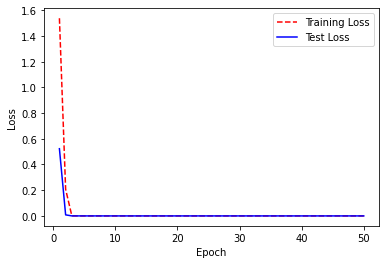

7/7 [==============================] - 0s 2ms/step


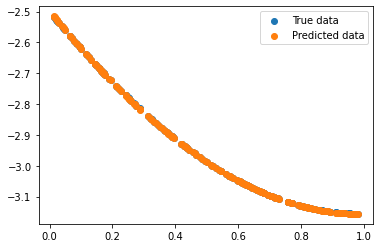

Run Time : 13.764754
7/7 [==============================] - 0s 2ms/step


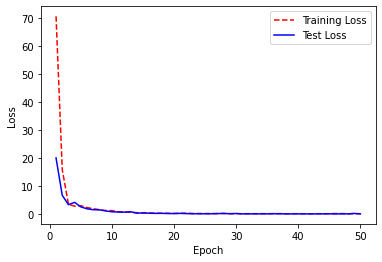

7/7 [==============================] - 0s 2ms/step


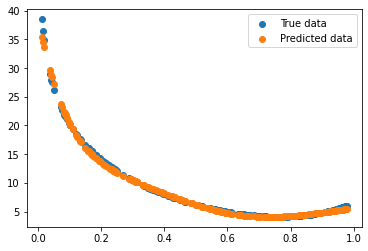

Run Time : 13.899881
7/7 [==============================] - 0s 2ms/step


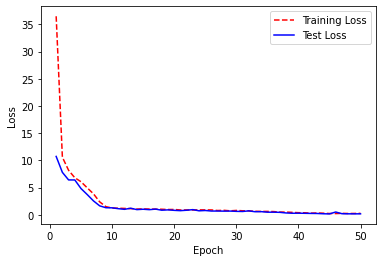

7/7 [==============================] - 0s 2ms/step


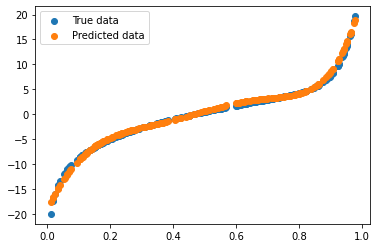

In [36]:
# this code is preparing data, training a model, and then visualizing the results of the model's performance. 
# The data preparation includes reshaping the data into the correct shape for the model and selecting a particular column of the data to use. 
# The model is then trained on this data for a specified number of epochs, and the time it takes to train the model is recorded.
# Finally, the model is used to make predictions on the test set, and the results are visualized.
#   The results of the model's performance, including the test data and predictions, are stored in the F_1_our_model variable.

# Preprocess data
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_2_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_3_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [37]:
#Second Traditional model for Function 3
archicture_1 = Sequential()
archicture_1.add(Dense(5, input_dim=input_dim, activation='relu'))
archicture_1.add(Dense(10, activation='relu'))
archicture_1.add(Dense(50, activation='tanh'))
archicture_1.add(Dense(18, activation='relu'))
archicture_1.add(Dense(15, activation='tanh'))
archicture_1.add(Dense(18, activation='sigmoid'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(8, activation='relu'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(output_dim, activation='relu'))
#model.summary()
archicture_1.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 16.798860
7/7 [==============================] - 0s 2ms/step


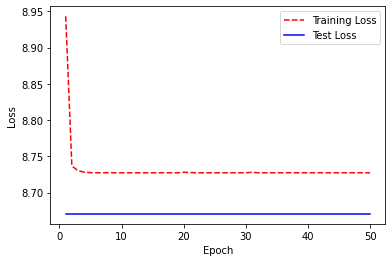

7/7 [==============================] - 0s 2ms/step


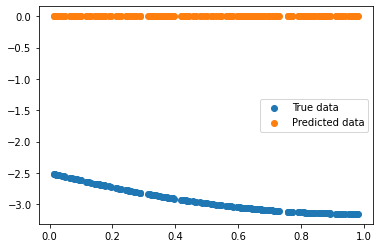

Run Time : 13.501772
7/7 [==============================] - 0s 2ms/step


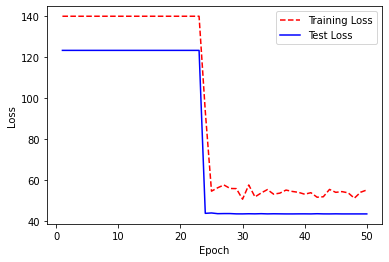

7/7 [==============================] - 0s 2ms/step


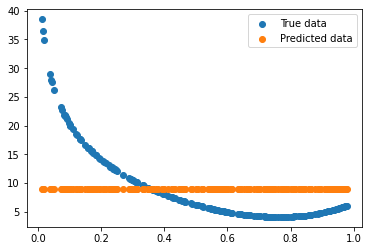

Run Time : 13.651231
7/7 [==============================] - 0s 2ms/step


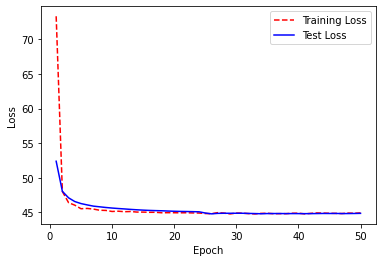

7/7 [==============================] - 0s 2ms/step


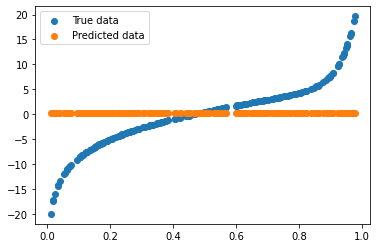

In [38]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

In [39]:
#Fifth Traditional Model
archicture_2 = Sequential()
archicture_2.add(Dense(5, input_dim=input_dim, activation='softplus'))
archicture_2.add(Dense(10, activation='softplus'))
archicture_2.add(Dense(20, activation='tanh'))
archicture_2.add(Dense(15, activation='relu'))
archicture_2.add(Dense(25, activation='tanh'))
archicture_2.add(Dense(20, activation='sigmoid'))
archicture_2.add(Dense(25, activation='relu'))
archicture_2.add(Dense(output_dim, activation='softplus'))
archicture_2.add(Dropout(0.2))
archicture_2.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 15.932294
7/7 [==============================] - 0s 2ms/step


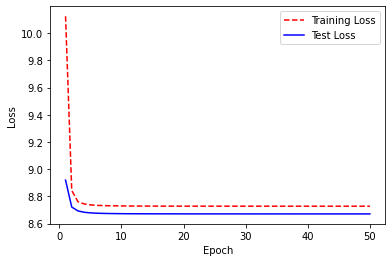

7/7 [==============================] - 0s 2ms/step


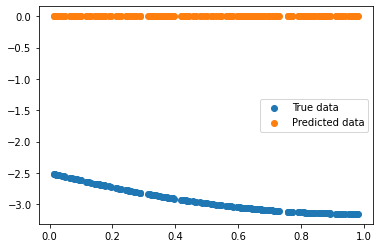

Run Time : 13.495484
7/7 [==============================] - 0s 2ms/step


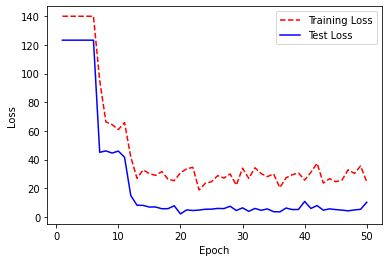

7/7 [==============================] - 0s 2ms/step


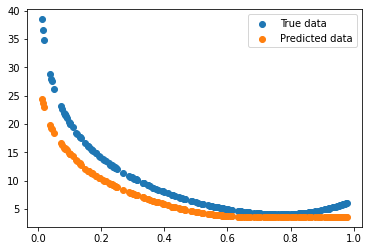

Run Time : 13.360016
7/7 [==============================] - 0s 2ms/step


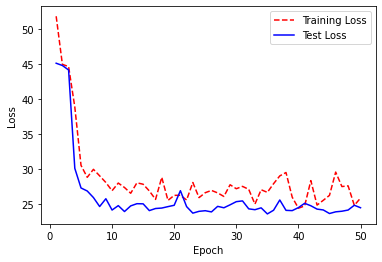

7/7 [==============================] - 0s 2ms/step


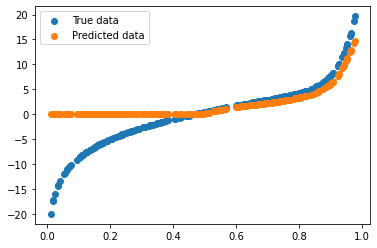

In [40]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/metrics_tracking.py:110: RuntimeWarning: All-NaN axis encountered
  np.nanmin(values) if self.direction == "min" else np.nanmax(values)


Run Time : 10.689932
7/7 [==============================] - 0s 2ms/step


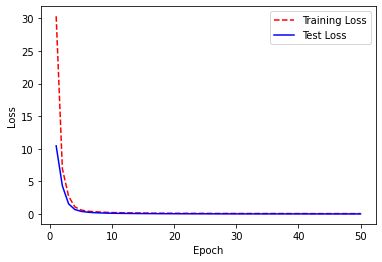

7/7 [==============================] - 0s 2ms/step


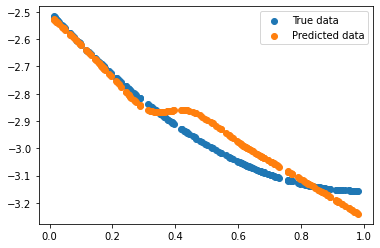

Run Time : 10.092567
7/7 [==============================] - 0s 2ms/step


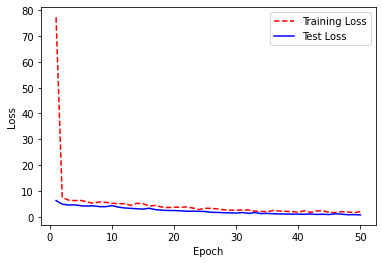

7/7 [==============================] - 0s 2ms/step


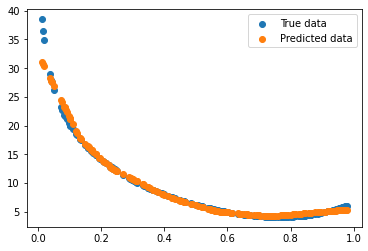

Run Time : 10.130498
7/7 [==============================] - 0s 2ms/step


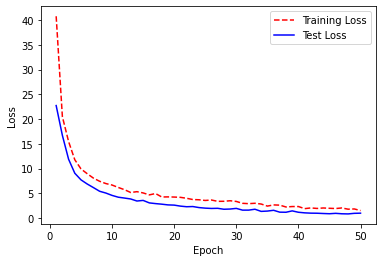

7/7 [==============================] - 0s 2ms/step


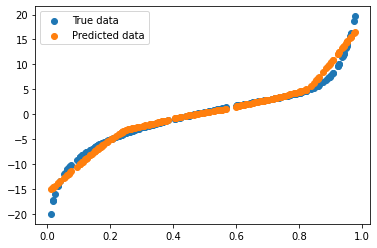

In [41]:
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)
)

clf = ak.StructuredDataRegressor(
    overwrite=True, max_trials=10
) 
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=5,verbose=0)
autokeras_model=clf.export_model()


column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [42]:
def create_optimal_model(best_param):
    """
    Create the optimal model using the best parameters obtained from GridSearchCV.

    :param best_param: dict, best parameters obtained from GridSearchCV
    :return: Keras model
    """

    model = Sequential()
    
    # Add the first layer with the best parameters
    model.add(Dense(best_param['neuron1'], input_dim=1, kernel_initializer=best_param['init'], activation=best_param['activation_function']))
    
    # Add the first dropout layer with the best dropout rate
    model.add(Dropout(best_param['dropout_rate']))
    
    # Add the second layer with the best parameters
    model.add(Dense(best_param['neuron2'], input_dim=best_param['neuron1'], kernel_initializer=best_param['init'], activation=best_param['activation_function_1']))
    
    # Add the second dropout layer with the best dropout rate
    model.add(Dropout(best_param['dropout_rate']))
    
    # Add the output layer with the best activation function
    model.add(Dense(1, activation=best_param['activation_function_2']))

    # Compile the model using Adam optimizer with the best learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_param['learning_rate'])
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    
    return model


In [43]:
def create_custom_model(learning_rate, dropout_rate, activation_function, activation_function_1, activation_function_2, init, neuron1, neuron2):
    """
    Create a Keras model with custom hyperparameters.

    :param learning_rate: float, learning rate for the optimizer
    :param dropout_rate: float, dropout rate for the Dropout layers
    :param activation_function: str, activation function for the first layer
    :param activation_function_1: str, activation function for the second layer
    :param activation_function_2: str, activation function for the output layer
    :param init: str, kernel initializer
    :param neuron1: int, number of neurons in the first layer
    :param neuron2: int, number of neurons in the second layer
    :return: Keras model
    """

    model = Sequential()
    model.add(Dense(neuron1, input_dim=1, kernel_initializer=init, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2, input_dim=neuron1, kernel_initializer=init, activation=activation_function_1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation_function_2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model

# Create the model
model = KerasRegressor(build_fn=create_custom_model, verbose=0)

# Define the grid search parameters
param_grids = {
    'batch_size': [10],
    'epochs': [10],
    'learning_rate': [0.01],
    'dropout_rate': [0.1],
    # 'activation_function': ['softmax', 'relu', 'tanh', 'linear'],
    # 'activation_function_1': ['softmax', 'relu', 'tanh', 'linear'],
    # 'activation_function_2': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function': ['softmax', 'relu'],
    'activation_function_1': ['softmax', 'relu'],
    'activation_function_2': ['softmax', 'relu'],
    'init': ['uniform'],
    'neuron1': [50],
    'neuron2': [20, ],
    # 'neuron1': [50, 100, 150],
    # 'neuron2': [20, 40, 80],
}

start = timeit.default_timer()

# Build and fit the GridSearchCV
kfold = KFold(n_splits=2)
grid = GridSearchCV(estimator=model, param_grid=param_grids, cv=kfold, verbose=0)
grid_result = grid.fit(X_train, Y_train)

# Summarize the results
print(f"Best score: {grid_result.best_score_}, using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev} with: {param}")

# Print runtime
end = timeit.default_timer()
print("Run Time : %f" % (end-start))


<ipython-input-43-1c1615d21ad8>:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_custom_model, verbose=0)


Best score: -23.955795288085938, using {'activation_function': 'relu', 'activation_function_1': 'relu', 'activation_function_2': 'relu', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-45.55869102478027, 2.864686965942383 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-37.13236999511719, 4.7063751220703125 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'relu', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 10, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-45.55869102478027, 2.864686965942383 with: {'activation_function': 'softmax', 'activation_function_1': 'relu', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, '

In [44]:
search_model=create_optimal_model(grid_result.best_params_)

Run Time : 11.278622
7/7 [==============================] - 0s 1ms/step


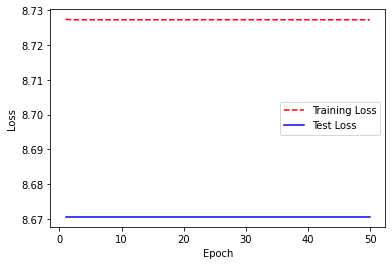

7/7 [==============================] - 0s 2ms/step


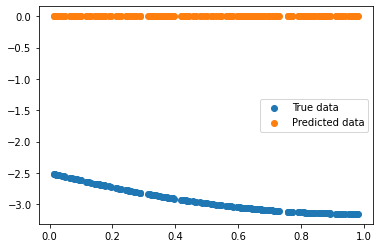

Run Time : 10.749448
7/7 [==============================] - 0s 2ms/step


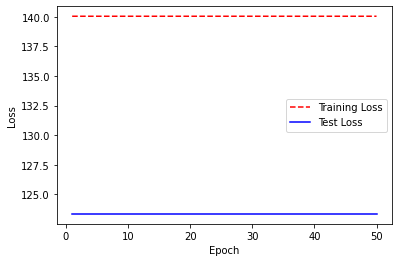

7/7 [==============================] - 0s 2ms/step


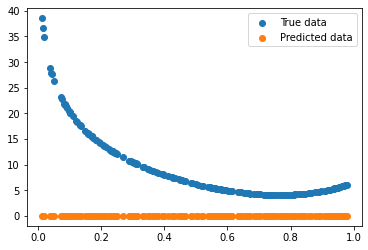

Run Time : 10.882396
7/7 [==============================] - 0s 2ms/step


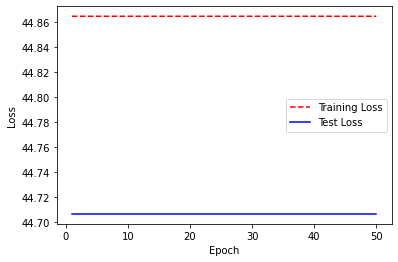

7/7 [==============================] - 0s 2ms/step


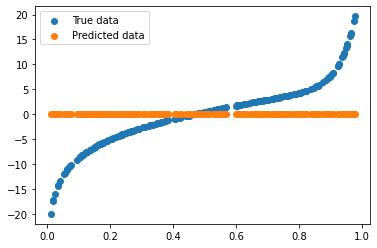

In [45]:



column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

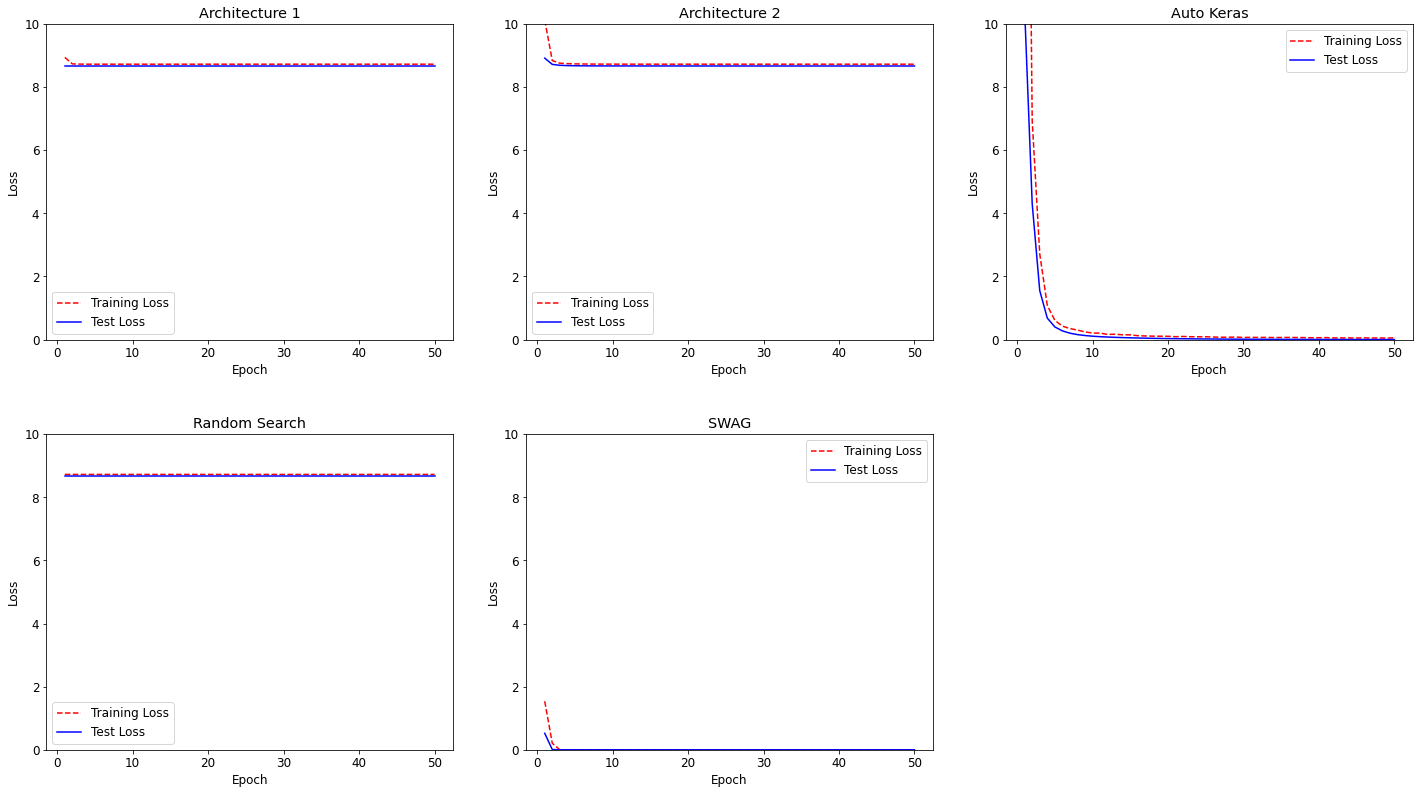

In [57]:





# Example usage
visualize_loss(10, [F_1_archicture_1[3], F_1_archicture_2[3], F_1_autokeras[3], F_1_Search[3], F_1_our_model[3]],
               ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])





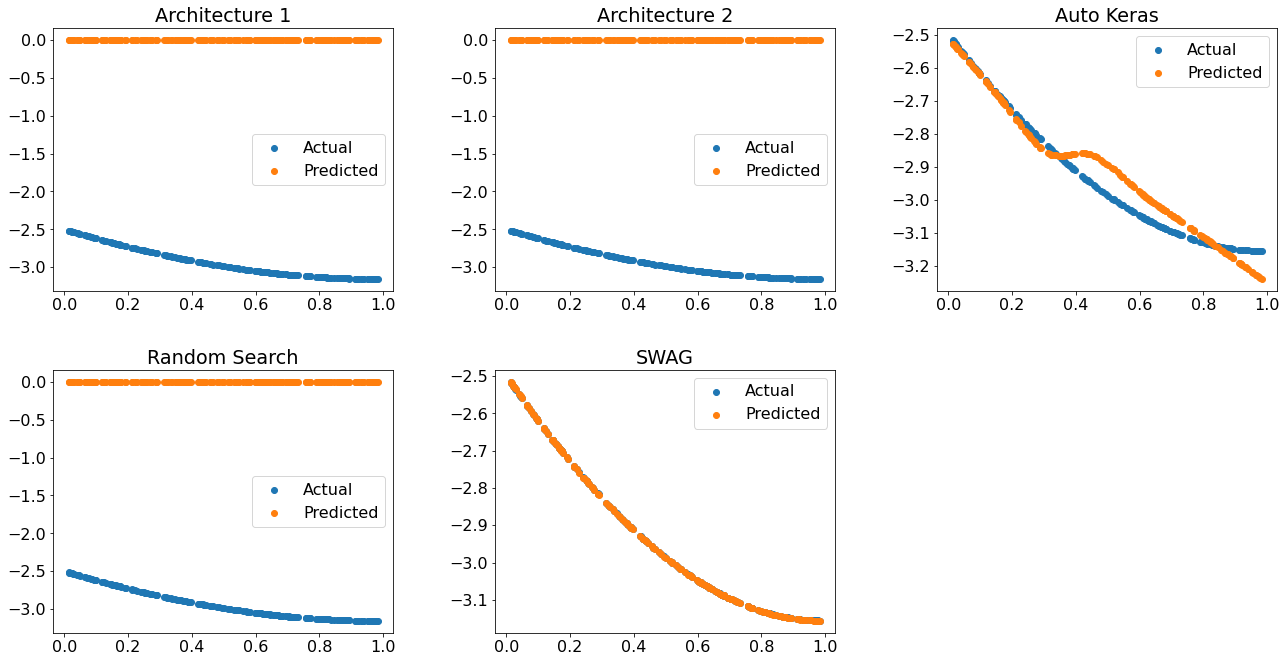

In [63]:
visualize_predictions([F_1_archicture_1, F_1_archicture_2, F_1_autokeras, F_1_Search, F_1_our_model],
                      ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])

In [47]:
#Plots Losses
plot_loss(15,F_1_archicture_1[3],F_1_archicture_2[3],F_1_autokeras[3],F_1_Search[3],F_1_our_model[3],)

TypeError: ignored

In [ ]:
#Plot Losses
visualize_loss(15,F_2_archicture_1[3],F_2_archicture_2[3],F_2_autokeras[3],F_2_Search[3],F_2_our_model[3],)

In [ ]:
#Plot Losses
visualize_loss(50,F_3_archicture_1[3],F_3_archicture_2[3],F_3_autokeras[3],F_3_Search[3],F_3_our_model[3],)

In [ ]:
#Plots Shapes
plot_shape(F_1_archicture_1,F_1_archicture_2,F_1_autokeras,F_1_Search,F_1_our_model,)

# plot_loss(15,F_1_archicture_1[3],F_1_archicture_2[3],F_1_autokeras[3],F_1_Search[3],F_1_our_model[3],)

In [ ]:
#Plots Shapes 
plot_shape(F_2_archicture_1,F_2_archicture_2,F_2_autokeras,F_2_Search,F_2_our_model,)


In [ ]:
#Plots Shapes
plot_shape(F_3_archicture_1,F_3_archicture_2,F_3_autokeras,F_3_Search,F_3_our_model,)


In [ ]:
import random
def rand_list():
  coefficient= [None for _ in range(8)]
  coefficient[0]= random.randint(-10, 10)
  coefficient[2]= random.randint(-10, 10)
  coefficient[4]= random.randint(-10, 10)
  coefficient[6]= random.randint(-10, 10)
  coefficient[1]= random.randint(1,50)
  coefficient[3]= random.randint(1,50)
  coefficient[5]= random.randint(1,50)
  coefficient[7]= random.randint(1,50)
  return coefficient


def fun_generator(co,x):
    return co[0]*power_(x, co[1])+co[2]*sigmoid_array(co[3]*x)+co[4]*exp_(co[5]*x*0.1)+co[6]*log_(co[7]*x)

In [ ]:
hidden_dimention = 50

for kk in range(10):  
  coefficient=rand_list()
  X1=X[:,0]
  Y1=fun_generator(coefficient,X1)
  X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.2,random_state=1234)

  Our_model=SWAG()
  coefficient=rand_list()
  start = timeit.default_timer()
  SWAG_history = Our_model.fit(X_train,Y_train,epochs=5,verbose=1,batch_size=10,validation_data=(X_test, Y_test)) 
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  plot_(SWAG_history)
  plt.scatter(X_test, Y_test)
  predict=Our_model.predict(X_test)
  plt.scatter(X_test, predict)
  print("SWAG Validation loss :"+str( SWAG_history.history['loss'][-1:]))
  # MSE = np.square(np.subtract(Y_train,predict)).mean()
  # print(MSE)
  plt.show()


  # Reshape data
  X_train = X_train.reshape(800, 1)
  Y_train = Y_train.reshape(800, 1)
  X_test = X_test.reshape(200, 1)
  Y_test = Y_test.reshape(200, 1)

  train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
  test_set = tf.data.Dataset.from_tensor_slices(
      (X_test, Y_test)
  )

  start = timeit.default_timer()


  clf = ak.StructuredDataRegressor(
      overwrite=True, max_trials=10
  ) 
  # Feed the tensorflow Dataset to the classifier.
  clf.fit(train_set, epochs=5,verbose=0)
  autokeras_model=clf.export_model()

  auto_history = autokeras_model.fit(X_train,Y_train,epochs=5,verbose=0,batch_size=10,validation_data=(X_test, Y_test)) 
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  plot_(auto_history)
  plt.scatter(X_test, Y_test)
  predict=autokeras_model.predict(X_test)
  plt.scatter(X_test, predict)
  print("Autokeras Validation loss "+str( auto_history.history['loss'][-1:]))
  # MSE = np.square(np.subtract(Y_train,predict)).mean()
  # print(MSE)
  plt.show()

In [ ]:
batch_size = 128
num_classes = 10
epochs = 4

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train+10
x_test = x_test+10

x_train /= 300
x_test /= 300
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

number_train=60000 
number_test=10000

x_train=x_train[0:number_train,:]
x_test=x_test[0:number_test,:]

y_train=y_train[0:number_train]
y_test=y_test[0:number_test]

In [ ]:
#Our Model optimize version
hidden_dimention=500
model = Sequential()

in_ = Input(shape=(784,))
Layer_1_X_1=Dense(hidden_dimention, activation='X_1')(in_)
################################################################
Layer_1_X_2=Dense(hidden_dimention, activation='X_2')(in_)
###############################################################
Concatenate_First_Layer = concatenate([Layer_1_X_1,Layer_1_X_2])

Layer__X_3_X_4=Dense(hidden_dimention, activation='X_2_')(Concatenate_First_Layer)
###############################################################


Concatenate_second_Layer = concatenate([Layer_1_X_1,Layer_1_X_2,Concatenate_First_Layer,Layer__X_3_X_4])

Out_put_first_layer=Dense(hidden_dimention, activation='linear')(Concatenate_second_Layer)


Out_put=Dense(10, activation='linear')(Out_put_first_layer)
model = Model(in_ , Out_put)
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')



optimizer =Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])
# Image(filename='model_2_layers.png')

start = timeit.default_timer()
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test))
end = timeit.default_timer()
print(end-start)


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_(history)

In [ ]:

start = timeit.default_timer()

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3) 
clf.fit(x_train, y_train, epochs=5)
scores = clf.evaluate(x_test, y_test, verbose=0)

end = timeit.default_timer()
print("Run Time : %f" % (end-start))

In [ ]:
autokeras_model=clf.export_model()

auto_history = autokeras_model.fit(x_train,y_train,epochs=5,verbose=0,batch_size=10,validation_data=(x_test, y_test)) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_(auto_history)